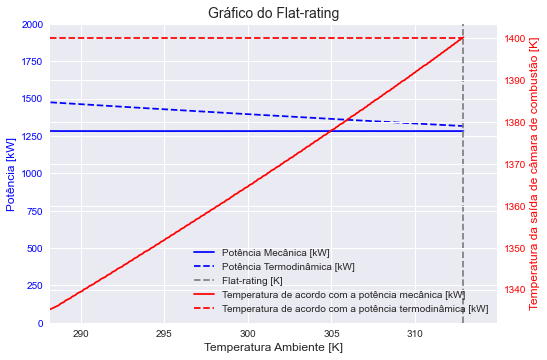

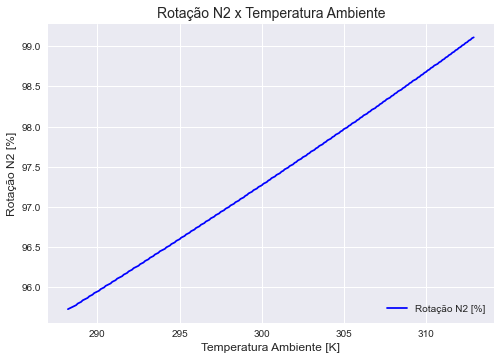

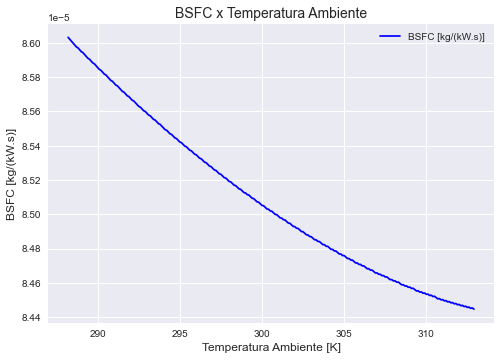

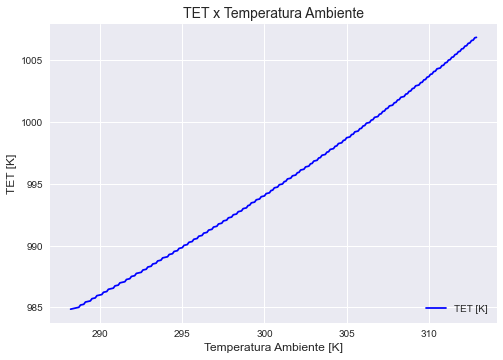

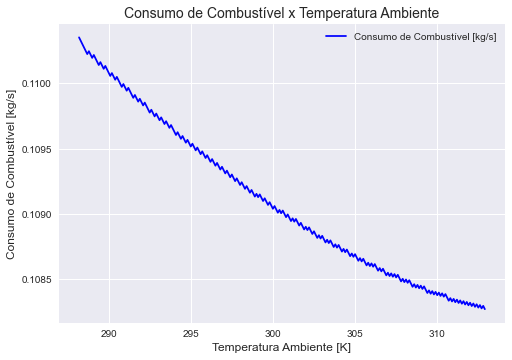

In [12]:
import model_reference as mf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings


# Set style
plt.style.use("seaborn")
warnings.filterwarnings('ignore')

values = {
    'mass_flow': 6.7,  
    't04': 1400,       
    'prc': 12,         
    'mach': 0,         
    'ta': 288.2,       
    'pa': 101.3,       
    'n_d': 0.85,       
    'gamma_d': 1.4,    
    'n_c': 0.75,       
    'gamma_c': 1.37,   
    'n_b': 1,          
    'gamma_b': 1.35,   
    'n_t': 0.9,        
    'gamma_t': 1.33,   
    'n_tl': 0.9,       
    'gamma_tl': 1.33,  
    'n_n': 0.98,       
    'gamma_n': 1.36,   
    'pc_fuel': 45000,  
    'cp_fuel': 1.110,  
    'cp_tls': 1.160,
    'cp_tl': 1.110,  
    'r': 288.3,        
    'pr_tl': 2.5153,                    
    'gearbox_power_ratio': 0.98,  
    'propeller_efficiency': 0.85, 
    }

values['pr_tl'] = 2.5153     # Value found in 4a for Ta = 288.2K, N2 = 1, T04 = 1400K
T04_target = 1400           # Temperature T04 of operation
N2 = 0.9573                 # Value found in 4a for Ta = 288.2K
N2_delta = 0.0001           # Delta N2
Ta = 288.2                  # Temperature Ta for ISA
Ta_delta = 0.1              # Delta Ta
turbine_power_target = 1282 # Limite of gearbox power

# Flags to break loops
found_flat_rating = False
found_N2_to_Ta = False

# Results
TAs = []
N2s = []
T04 = []
BSFC = []
TET = []
fuel_consumption = []
mecanic_power = []
thermodynamic_power = []
T04_op = []

while not found_flat_rating:
    found_N2_to_Ta = False
    values['ta'] = Ta
    turboprop = mf.TurboProp(values)

    # Get result for Ta when N2 = 100%
    turboprop.set_n2(1)
    performance_results_op = turboprop.sumarise_results()
    thermodynamic_results_op = turboprop.sumarise()

    while not found_N2_to_Ta:
        N2 = N2 + N2_delta
        turboprop.set_n2(N2)
        performance_results = turboprop.sumarise_results()
        if int(performance_results.loc['turbine_power']) > turbine_power_target:
            found_N2_to_Ta = True
            N2 = N2 - N2_delta
        elif int(performance_results.loc['turbine_power']) == turbine_power_target:
            found_N2_to_Ta = True

    # Get result for Ta and N2 when mecanic power is 1282kW
    turboprop.set_n2(N2)
    performance_results = turboprop.sumarise_results()
    thermodynamic_results = turboprop.sumarise()

    # Get results of Ta
    TAs.append(Ta)
    N2s.append(N2)
    T04.append(float(thermodynamic_results.loc['t04']))
    BSFC.append(float(performance_results.loc['BSFC']))
    TET.append(float(thermodynamic_results.loc['t05']))
    fuel_consumption.append(float(performance_results.loc['fuel_consumption']))
    mecanic_power.append(float(performance_results.loc['turbine_power']))
    thermodynamic_power.append(float(performance_results_op.loc['turbine_power']))
    T04_op.append(float(thermodynamic_results.loc['t04']))

    # When T04 calculated is equal to 1400K, so is flat rating
    if int(thermodynamic_results.loc['t04']) >= T04_target:
        found_flat_rating = True
    else:
        Ta = Ta +Ta_delta # Update Ta
    
# Plot informations


'''
    Flat-rating Graph 
'''
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# set title
plt.title("Gráfico do Flat-rating",fontsize=14)
# make a plot
plot1, = ax.plot(TAs, mecanic_power, color="blue", label='Potência Mecânica [kW]')
plot2, = ax.plot(TAs, thermodynamic_power, 'b--', label='Potência Termodinâmica [kW]')
plot3 = ax.vlines(x = max(TAs), ymin= 0, ymax= 2000, color ='gray', linestyle='--', label='Flat-rating [K]')
# set x-axis label
ax.set_xlabel("Temperatura Ambiente [K]",fontsize=12)
# set y-axis label
ax.set_ylabel("Potência [kW]",color="blue",fontsize=12)
# set y-axis color
ax.tick_params(axis ='y', labelcolor = 'blue')
# set y-axis limits
ax.set_ylim(0,2000)

# set x-axis limits
ax.set_xlim(min(TAs),max(TAs)+2)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
plot4, = ax2.plot(TAs, T04, color="red", label='Temperatura de acordo com a potência mecânica [kW]')
plot5 = ax2.hlines(y = T04_target, xmin= min(TAs), xmax= max(TAs), color ='red', linestyle='--', label='Temperatura de acordo com a potência termodinâmica [kW]')

# set y-axis label
ax2.set_ylabel("Temperatura da saída de câmara de combustão [K]",color="red",fontsize=12)
# set y-axis color
ax2.tick_params(axis ='y', labelcolor = 'red')

# Add legends
ax.legend(handles=[plot1, plot2, plot3, plot4, plot5], loc='lower right')

# Show plot
plt.show()

# save the plot as a file
fig.savefig('images/questao4/flat_rating.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

'''
    N2 x Temperatura Ambiente Graph
'''
# create figure and axis objects with subplots()
fig2,ax = plt.subplots()
# set title
plt.title("Rotação N2 x Temperatura Ambiente",fontsize=14)
# make a plot
ax.plot(TAs, [x * 100 for x in N2s] , color="blue", label='Rotação N2 [%]')
# set x-axis label
ax.set_xlabel("Temperatura Ambiente [K]",fontsize=12)
# set y-axis label
ax.set_ylabel("Rotação N2 [%]",fontsize=12)
# Add legends
ax.legend(loc='lower right')

# Show plot
plt.show()

# save the plot as a file
fig2.savefig('images/questao4/rotacao_tempAmb.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

'''
    BSFC x Temperatura Ambiente Graph 
'''
# create figure and axis objects with subplots()
fig3,ax = plt.subplots()
# set title
plt.title("BSFC x Temperatura Ambiente",fontsize=14)
# make a plot
ax.plot(TAs, BSFC, color="blue", label='BSFC [kg/(kW.s)]')
# set x-axis label
ax.set_xlabel("Temperatura Ambiente [K]",fontsize=12)
# set y-axis label
ax.set_ylabel("BSFC [kg/(kW.s)]",fontsize=12)

# Add legends
ax.legend(loc='upper right')

# Show plot
plt.show()

# save the plot as a file
fig3.savefig('images/questao4/BSFC_tempAmb.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

'''
    TET x Temperatura Ambiente Graph
'''
# create figure and axis objects with subplots()
fig4,ax = plt.subplots()
# set title
plt.title("TET x Temperatura Ambiente",fontsize=14)
# make a plot
ax.plot(TAs, TET, color="blue", label='TET [K]')
# set x-axis label
ax.set_xlabel("Temperatura Ambiente [K]",fontsize=12)
# set y-axis label
ax.set_ylabel("TET [K]",fontsize=12)

# Add legends
ax.legend(loc='lower right')

# Show plot
plt.show()

# save the plot as a file
fig4.savefig('images/questao4/TET_tempAmb.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

'''
    Consumo de Combustível x Temperatura Ambiente Graph
'''
# create figure and axis objects with subplots()
fig5,ax = plt.subplots()
# set title
plt.title("Consumo de Combustível x Temperatura Ambiente",fontsize=14)
# make a plot
ax.plot(TAs, fuel_consumption, color="blue", label='Consumo de Combustível [kg/s]')
# set x-axis label
ax.set_xlabel("Temperatura Ambiente [K]",fontsize=12)
# set y-axis label
ax.set_ylabel("Consumo de Combustível [kg/s]",fontsize=12)

# Add legends
ax.legend(loc='upper right')

# Show plot
plt.show()

# save the plot as a file
fig5.savefig('images/questao4/consComb_tempAmb.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')
